# Chapter 2 - Random Graph Models

In the first part of this notebook, we provide the code required to generate the Figures in Chapter 2 of the textbook.

In the second part, we consider the GitHub ml developers graph that we introduced in Chapter 1, and compare various statistics for this graph with the values we get for the random graphs models introduced in Chapter 2.

### Requirements

We use one new package in this notebook called ```plfit``` which can be installed via ```pip install plfit```.
In case of error when pip installing, you can copy the code from the GitHub repository: https://github.com/keflavich/plfit

As with the previous notebook, make sure to set the data directory properly in the next cell.


In [1]:
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import plfit
from scipy.stats import poisson


# Part 1 - Generating Figures for Chapter 2

## Figure 2.1: size of the giant component

We generate several binomial random graphs with $n$ nodes, where we vary the average node degree (thus, the number of edges). We consider $n=100$ below, and you can try for different $n$. Un-comment the second line to run with $n=10000$ nodes as in the book (this will be much slower).

We plot the theoretical giant component size (black line) and the 90% confidence interval from empirical data in grey, both as a function of the average degree; we see good agreement and we observe the various phases as described in the book. 

/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  if sys.path[0] == "":


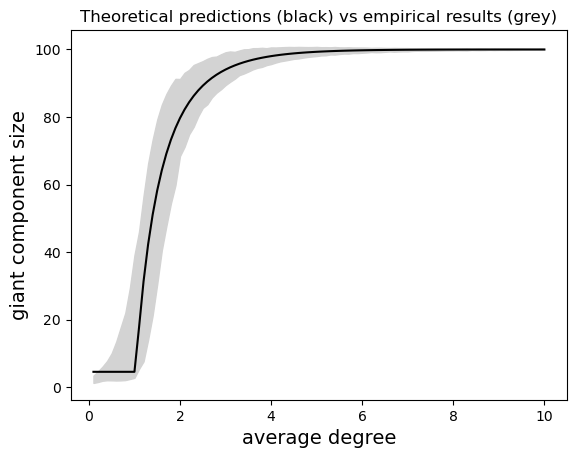

In [3]:
n = 100
# n=10000
gc_avg = []
gc_std = []
REP = 1000 ## repeats
ad = np.arange(.1,10.1,.1)
for d in ad:
    x = []
    p = d/(n-1)
    for rep in range(REP):
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(g.clusters().giant().vcount())
    gc_avg.append(np.mean(x))
    gc_std.append(np.std(x))

## theoretical
th = [np.log(n) for i in np.arange(.1,1.1,.1)]
from scipy.optimize import fsolve
def fn(x,d):
    return x+np.exp(-x*d)-1
for i in np.arange(1.1,10.1,.1):
    th.append(n*fsolve(fn,1,args=(i))[0])

plt.fill_between(ad,[x[0]-1.654*x[1] for x in zip(gc_avg,gc_std)],
                 [x[0]+1.645*x[1] for x in zip(gc_avg,gc_std)],color='lightgray')
plt.plot(ad,th,color='black')
plt.title('Theoretical predictions (black) vs empirical results (grey)')
plt.xlabel('average degree',fontsize=14)
plt.ylabel('giant component size',fontsize=14);

## un-comment to save plot in a file
#plt.savefig('giant_100.eps');

## Figure 2.2: probability that the graph is connected

This is a similar experiment as above, but this time we look at the probability that the random graph is connected.
We vary some constant $c$ introduced in the book such that edge probability for the binomial graphs is given by $(\log(n)+c)/n$. Once again we compare theory (black line) and experimental results (in grey), with $n=100$ nodes and you can try for different $n$. Un-comment the second line to run with $n=10000$ nodes as in the book (this will be much slower).

In the cell below, the grey area corresponds to a 90% confidence interval for proportions; for empirical proportion $x$ obtained from sample of size $n$, the formula is given by $x \pm 1.645 \sqrt{x(1-x)/n}$.

Here also we see good agreement between theory and experimental results.

In [30]:
-int(np.floor(np.log(n)*10))/10

-4.6

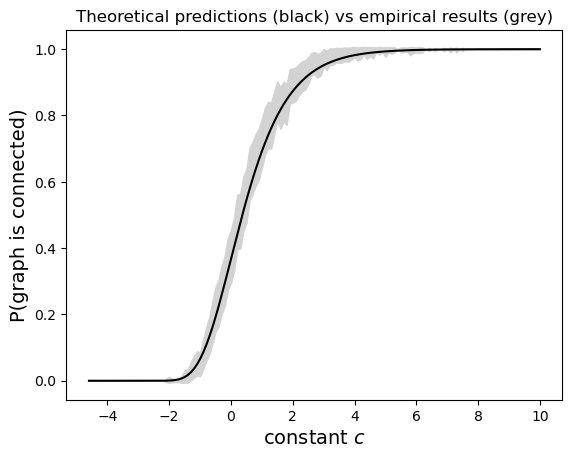

In [4]:
n = 100
#n = 10000
REP = 1000 ## repeats
lo = -int(np.floor(np.log(n)*10))/10
if lo<-10:
    lo = -10
C = np.arange(lo,10.1,.1)
ic_avg=[]
for c in C:
    x = []
    p = (c+np.log(n))/n
    for rep in range(REP):        
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(int(g.is_connected()))
    ic_avg.append(np.mean(x))

## theoretical
th = [np.exp(-np.exp(-c)) for c in C]

## plot
plt.fill_between(C,[x-1.654*np.sqrt(x*(1-x)/n) for x in ic_avg],
                 [x+1.645*np.sqrt(x*(1-x)/n) for x in ic_avg],color='lightgray')
plt.plot(C,th,color='black')
plt.title('Theoretical predictions (black) vs empirical results (grey)')
plt.xlabel(r'constant $c$',fontsize=14)
plt.ylabel('P(graph is connected)',fontsize=14);

## un-comment to save plot in a file
#plt.savefig('connected_100.eps');

## Figure 2.4: Distribution of shortest path lengths

We consider a series of binomial random graphs with expected average degree 5, where we vary the number of nodes from $n=50$ to $n=3200$.

We see that as we double the number of nodes, the average shortest path lengths increases slowly.


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  
/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  import sys


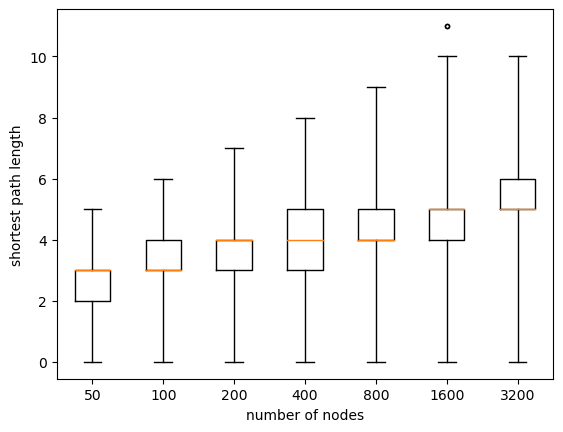

In [5]:
sp = []
N = [50,100,200,400,800,1600,3200]
for n in N:
    p = 5/(n-1)
    ## keep giant component
    g = ig.Graph.Erdos_Renyi(n=n, p=p).clusters().giant()
    z = g.shortest_paths()
    sp.append([x for y in z for x in y])
## plot    
plt.boxplot(sp, labels=N, sym='.',whis=5)
plt.ylabel('shortest path length')
plt.xlabel('number of nodes');
## un-comment to save plot in a file
# plt.savefig('path_len.eps')

## Figure 2.5 Poisson vs degree distributions

We plot the degree distribution for binomial random graphs with expected average degree 10, and $n=100$ nodes (the black dots), and we compare with the corresponding Poisson distributed (dashed line).

Try increasing $n$; the dots should get closer to the Poisson distribution, with more stable results if you try multiple runs.

Un-comment line 2 to run with $n=10000$ as in the book.


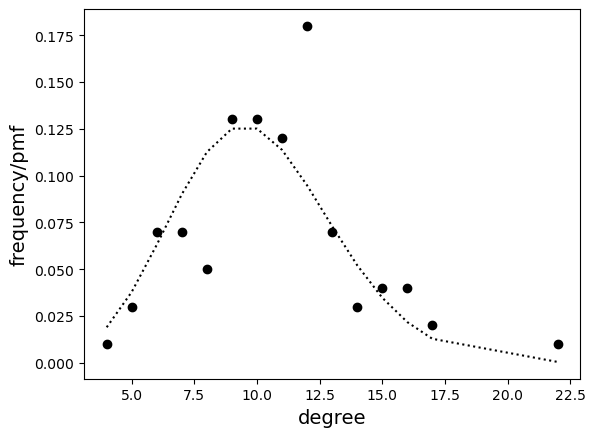

In [6]:
n = 100
#n = 10000
p = 10/(n-1)
g = ig.Graph.Erdos_Renyi(n=n, p=p)
x = [x[0] for x in sorted(Counter(g.degree()).items())]
pmf = [poisson.pmf(k,10) for k in x]
frq = [x[1]/n for x in sorted(Counter(g.degree()).items())]
plt.plot(x,frq,'o',color='black')
plt.plot(x,pmf,':',color='black')
plt.xlabel('degree',fontsize=14)
plt.ylabel('frequency/pmf',fontsize=14);


## Figure 2.6 --  Power law graphs

We generate a random graph with $n=10,000$ nodes following power law degree distribution with exponent $\gamma=2.5$.
We do so using the Chung-Lu models described in section 2.5 of the book, and we discard 0-degree nodes.

We then fit and plot the degree distribution of the obtained graph using the ```plfit``` package https://pypi.org/project/plfit/


In [7]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples


In [8]:
## power law graph
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl)

## number of isolated nodes (no edges)
iso = n-g1.vcount()
print('isolates:',iso)


isolates: 1868


(8, 2.7457584663112984)


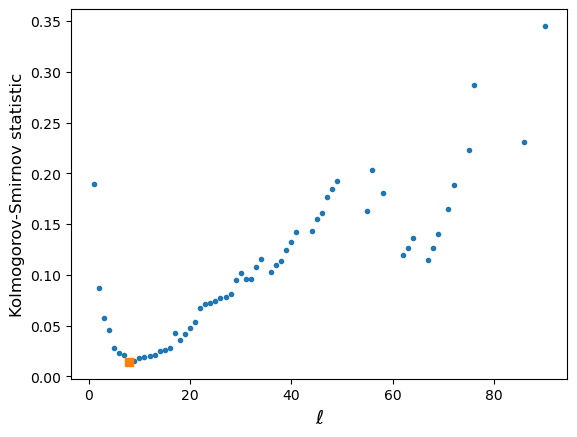

In [9]:
## run plfit and compute K-S statistic (details in the book)
d = g1.degree()
X = plfit.plfit(d)

## those are gamma' and l' minimizing divergence from the tail of the power law distribution
print(X.plfit())

## plot K-S statistics vs. cutoff value l
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [10]:
## K-S test - this can take a few minutes
# Monte-Carlo test to determine whether distribution is consistent with a power law
KS_tst = X.test_pl(niter=100)

p(100) = 1.000


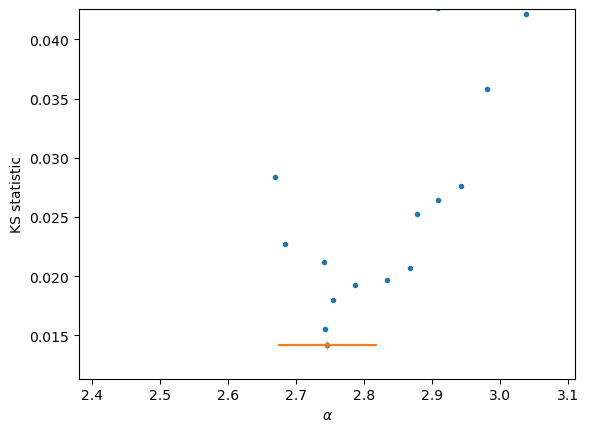

In [11]:
## plot K-S statistics vs. exponent (alpha here, gamma' in the book)
ax = plt.figure(1)
ax = X.alphavsks()

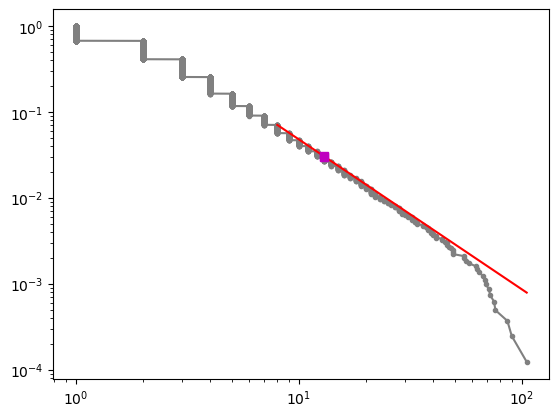

In [12]:
## inverse cdf along with fitted line (as with Figure 2.6 in the book)
X.plotcdf(pointcolor='grey', pointmarker='.',zoom=False)


## Figure 2.7: simple d-regular graphs

We generate several $d$-regular graphs and count how many are simple graphs.
We consider $d=2$ to $d=10$, with $n=100$ nodes. You can try for different $n$. Un-comment the second line to run with $n=10000$ nodes as in the book (this will be much slower).

We plot the empirical proportion of simple graphs below (black dots), and we compare with the theoretical values (dashed line). We see good agreement even for small value $n=100$.


In [13]:
n = 100
# n = 10000
REP = 100
D = np.arange(2,11) 
simple = []
for d in D:
    x = 0
    for rep in range(REP):
        g = ig.Graph.Degree_Sequence([d for i in range(n)])
        x += int(g.is_simple())
    simple.append(x/REP)
th = [np.exp(-(d*d-1)/4) for d in D]

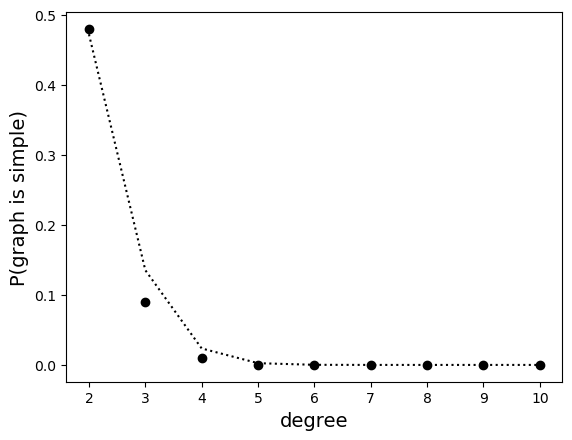

In [14]:
plt.plot(D,simple,'o',color='black')
plt.plot(D,th,':',color='black')
plt.xlabel('degree',fontsize=14)
plt.ylabel('P(graph is simple)',fontsize=14);

# Part 2 -- Experiments section

We use the giant component of the GitHub machine learning (ml) developers subgraph that we introduced in Chapter 1. Recall this graph has 7,083 nodes and 19,491 edges. 

We compute several graphs statistics for this "base graph", as reported in the first column of Table 2.8 from the book.

We then generate random graphs with the same number of nodes and edges using 4 different models:
* binomial (only average degree)
* Chung-Lu (expected degree distribution)
* Configuration (exact degree distribution)
* Configuration with Viger method (connected, simple graph is obtained)

See section 2.8 of the book for a discussion of the results bit as a general observation, more complex models (such as the configuration model with Viger method) tend to preserve more characteristics of the reference graph.


In [15]:
## read the GitHub edge list into a graph (gh)
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## Add some node features;
## There are 2 class of nodes
## 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

## for github, 9739 are ml developers, build the subgraph
gh_ml = gh.subgraph([v for v in gh.vs() if v['color']=='black'])

## keep the giant component
sg = gh_ml.clusters().giant()
print(sg.vcount(),'nodes and',sg.ecount(),'edges')

7083 nodes and 19491 edges


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead


In [16]:
## return statistics from Table 2.8 for graph G
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.max(deg),G.diameter(),
     np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),sum([x==0 for x in G.degree()]),
     G.transitivity_undirected(),G.transitivity_avglocal_undirected()]
  

In [17]:
## statistice for Base and random graphs
S = []
S.append(['Base Graph'] + baseStats(sg))
## Random (Erdos-Renyi) graph with same number of nodes and edges
er = ig.Graph.Erdos_Renyi(n=sg.vcount(), m=sg.ecount())
S.append(['Erdos-Renyi'] + baseStats(er))
## Random (Chung-Lu) graph with same degree distribution
tpl = fastCL(sg.degree(),sg.ecount()) 
cl = ig.Graph.Erdos_Renyi(n=sg.vcount(),m=0)
cl.add_edges(tpl)
S.append(['Chung-Lu'] + baseStats(cl))
## Random (configuration model) graph with same degree distribution
cm = ig.Graph.Degree_Sequence(sg.degree(),method='simple')
S.append(['Configuration'] + baseStats(cm))
## Random graph with same degree distribution using the
## configuration model with VL method, which yield a simple graph
cmvl = ig.Graph.Degree_Sequence(sg.degree(),method='vl')
S.append(['Configuration (VL)'] + baseStats(cmvl))


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  """


In [18]:
## Store in dataframe and show results
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',
                             r'$d_{median}$',r'$d_{max}$','diameter','components','largest','isolates',
                             r'$C_{glob}$',r'$C_{loc}$'])
D = D.transpose()
D

,0,1,2,3,4
graph,Base Graph,Erdos-Renyi,Chung-Lu,Configuration,Configuration (VL)
nodes,7083,7083,7083,7083,7083
edges,19491,19491,19491,19491,19491
$d_{min}$,1,0,0,1,1
$d_{mean}$,5.5036,5.5036,5.5036,5.5036,5.5036
$d_{median}$,2.0,5.0,3.0,2.0,2.0
$d_{max}$,482,16,446,482,482
diameter,13,11,10,10,11
components,1,29,1053,63,1
largest,7083,7055,6006,6954,7083


### shortest path length distribution

We compute and compare the minimum path length distribution for several node pairs and for the 5 graphs we have (reference and 4 random ones). Sampling can be used to speed-up the process.

We consider the giant component for disconnected graphs.

We see a reasonably high similarity for all graphs, with the binomial random graph having slightly longer path lengths due to the absence of high degree (hub) nodes in that model.


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  """
/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  
/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  import sys
/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
/Users/hoangnguyen/mi

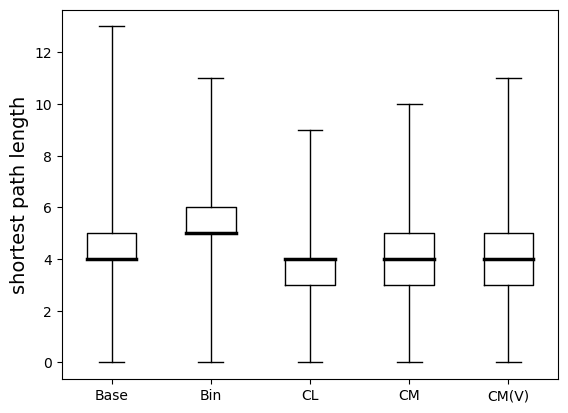

In [19]:
## sampling -- doing all vertices is slower
size = 1000

## using the giant component for disconnected graphs
er_g = er.clusters().giant()
cl_g = cl.clusters().giant()
cm_g = cm.clusters().giant()

## to consider all vertices, replace the code below with:
# sp_sg = [i for v in sg.shortest_paths(source=None) for i in v]
# sp_er = [i for v in er_g.shortest_paths(source=None) for i in v]
# sp_cl = [i for v in cl_g.shortest_paths(source=None) for i in v]
# sp_cm = [i for v in cm_g.shortest_paths(source=None) for i in v]
# sp_cmvl = [i for v in cmvl.shortest_paths(source=None) for i in v]

# to use sampling:
## NB: we sample separately since we use the giant components and graphs may
##     have a different number of nodes (except the first and last one)
sp_sg = []
for v in np.random.choice(sg.vcount(),size=size,replace=False):
    sp_sg.extend(sg.shortest_paths(source=v)[0])
sp_er = []
for v in np.random.choice(er_g.vcount(),size=size,replace=False):
    sp_er.extend(er_g.shortest_paths(source=v)[0])
sp_cl = []
for v in np.random.choice(cl_g.vcount(),size=size,replace=False):
    sp_cl.extend(cl_g.shortest_paths(source=v)[0])
sp_cm = []
for v in np.random.choice(cm_g.vcount(),size=size,replace=False):
    sp_cm.extend(cm_g.shortest_paths(source=v)[0])
sp_cmvl = []
for v in np.random.choice(cmvl.vcount(),size=size,replace=False):
    sp_cmvl.extend(cmvl.shortest_paths(source=v)[0])

## generate boxplots   
plt.boxplot([sp_sg,sp_er,sp_cl,sp_cm,sp_cmvl],labels=['Base','Bin','CL','CM','CM(V)'],
            sym='.',whis=10, medianprops = dict(linestyle='-', linewidth=2.5,color='black'))
plt.ylabel('shortest path length',fontsize=14);

## save plot to file
#plt.savefig('pathlen_box.eps');

# Extra material

## More power law tests - GitHub subgraphs and Grid graph

We try to fit power law for degree distribution as we did before, this time for 3 real graphs:
* GitHub ml developers (giant component)
* GitHub web developers (giant component)
* Grid (Europe power grid graph, giant component)

While the first two exhibit power law degree distribution, this is clearly not the case for the Grid graph.


### GitHub ml subgraph

(15, 2.6233219324266894)


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  after removing the cwd from sys.path.


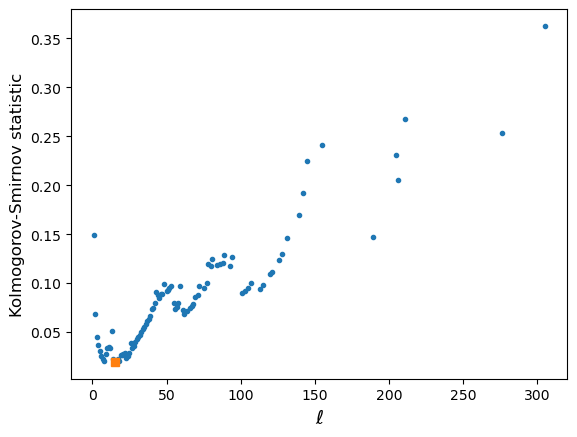

In [20]:
## for github, 9739 are ml developers, build the subgraph
gh_ml = gh.subgraph([v for v in gh.vs() if v['color']=='black'])
## keep the giant component
sg = gh_ml.clusters().giant()

## estimates for xmin and gamma
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [21]:
## K-S test -- very good fit here
KS_tst = X.test_pl(niter=100)

p(100) = 0.990


### GitHub web subgraph

(46, 2.5059946710270755)


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  after removing the cwd from sys.path.


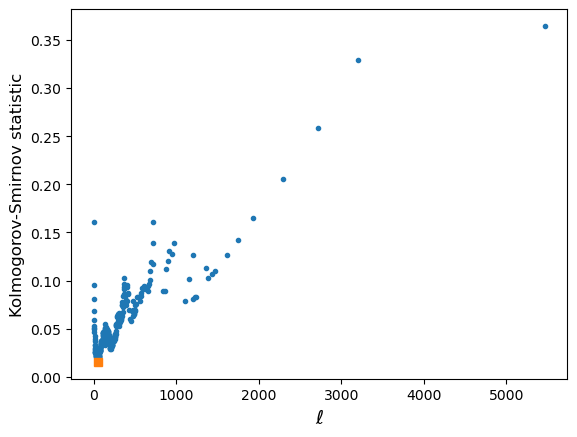

In [22]:
## github web developers subgraph
gh_web = gh.subgraph([v for v in gh.vs() if v['color']!='black'])
## keep the giant component
sg = gh_web.clusters().giant()

## estimates for xmin and gamma
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [23]:
## KS test -- not as good as previous graph, but still consistent with power law
## (if p<.1, the data may be inconsistent with a powerlaw.)
KS_tst = X.test_pl(niter=100)

p(100) = 0.320


### Grid graph

(15, 19.04585348531464)


/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  after removing the cwd from sys.path.


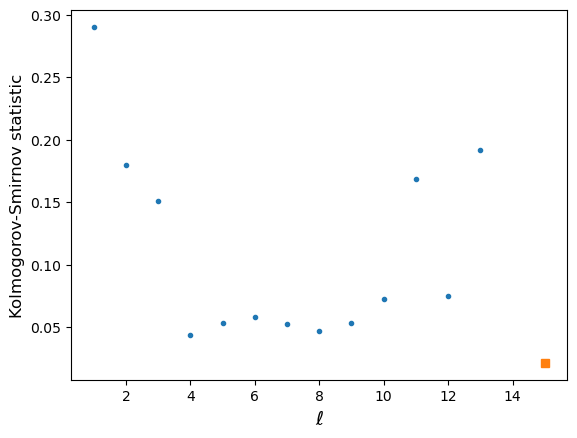

In [24]:
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()
## keep the giant component
sg = gr.clusters().giant()

## estimates for xmin and gamma
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [25]:
## we get xmin=15 ... how many nodes does this cover? --> just a few!
sum([x>=15 for x in sg.degree()])

3

In [26]:
## let's fix xmin=4 to cover more nodes!
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit(xmin=4))

xmin: 4 n(>xmin): 1447 alpha: 5.86011 +/- 0.127765   Log-Likelihood: -1462.9   ks: 0.524534 p(ks): 0
(4, 5.860107700269038)


In [27]:
## K-S test -- highly likely not power law
KS_tst = X.test_pl(niter=100)

p(100) = 0.000


## Independent sets

Illustrating a few functions to find independent sets.

In [28]:
## generate random graph with (at least one) independent set 
## n: nodes, s: independent set size, d: avg degree
def indepSet(n,s,d):
    N = n-s
    di = n*d//2-s*d
    ## random graph with N nodes
    g = ig.Graph.Erdos_Renyi(n=N,m=di)
    ## extra nodes
    g.add_vertices(s)
    ## assign remaining degree to extra nodes
    z = np.random.choice(np.arange(N,n),size=s*d)
    deg = [x[1] for x in sorted(Counter(z).items())]
    for i in range(len(deg)):
        e = np.random.choice(N,deg[i],replace=False)
        for j in e:
            g.add_edge(j,i+N)
    p = list(np.random.permutation(n))
    G = g.permute_vertices(p)
    return G


In [29]:
g = indepSet(50, 10, 20)

## every set of size min or mode
#ivs = g.independent_vertex_sets(min=9)

## largest set(s) only
ivs = g.largest_independent_vertex_sets()

## maximal sets (that can't be extended)
#ivs = g.maximal_independent_vertex_sets()

print(g.independence_number())

ivs

10


[(6, 14, 18, 21, 25, 26, 28, 37, 40, 43),
 (14, 18, 21, 22, 25, 26, 28, 37, 40, 43)]